## 2D Tracking Problem

In [2]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

def f_cv(x, dt):
    """ state transition function for a 
    constant velocity robot"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return x[[0, 2]]

In [3]:
import numpy as np
import pandas as pd
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp

df = pd.read_csv('pentagon.csv')
uwb_x = df.uwb_x
uwb_y = df.uwb_y
vel_linear_x = df['vel_linear_x'].fillna(0.0)

# first nonzero value for uwb_x
ini_index = uwb_x.ne(0).idxmax()

process_std = 0.028
process_var = 0.028 ** 2
process_var_lateral = 0.019 ** 2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2
sensor_bigger_var = 0.3 ** 2

dt = 1.0
# KF for comparison
kf = KalmanFilter(4, 2)
kf.x = np.array([uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0.])
kf.R = np.diag([sensor_var, sensor_var_lateral])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=process_var)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=process_var_lateral)

zs = [np.array([uwb_x[i], 
                uwb_y[i]]) for i in range(ini_index, len(uwb_x))]

xs, _, _, _ = kf.batch_filter(zs)

# UKF implementation

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UnscentedKalmanFilter(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([uwb_x[ini_index], vel_linear_x[0], uwb_y[ini_index], 0.])
ukf.R = np.diag([sensor_var, sensor_var_lateral])
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=process_var)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=process_var_lateral)

# uxs = []
# for z in zs:
#     ukf.predict()
#     ukf.update(z)
#     uxs.append(ukf.x.copy())
uxs, covs = ukf.batch_filter(zs)
Ms, P, K = ukf.rts_smoother(uxs, covs)

In [4]:
Ms

array([[ 3.84985577e+00,  4.01015237e-04,  6.70722527e-01,
        -1.17034978e-04],
       [ 3.85026189e+00,  4.11230996e-04,  6.70601091e-01,
        -1.25836802e-04],
       [ 3.85067867e+00,  4.22333770e-04,  6.70458858e-01,
        -1.58628527e-04],
       ...,
       [ 5.52000000e+00,  1.36569105e-14,  5.90000000e-01,
        -4.64549856e-16],
       [ 5.52000000e+00,  1.12998883e-14,  5.90000000e-01,
        -5.78052317e-16],
       [ 5.52000000e+00,  1.07377431e-14,  5.90000000e-01,
        -5.98287607e-16]])

UKF standard deviation 0.000 meters


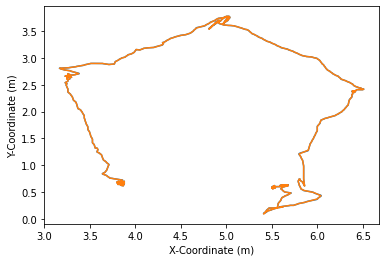

In [5]:
uxs = np.array(uxs)
# print(uxs)
plt.plot(Ms[:, 0], Ms[:, 2])
plt.plot(uwb_x[ini_index:], uwb_y[ini_index:])
plt.xlabel('X-Coordinate (m)')
plt.ylabel('Y-Coordinate (m)')
# bp.plot_measurements(zs[:, 0], zs[:, 1])
print('UKF standard deviation {:.3f} meters'.format(np.std(uxs - xs)))

In [6]:
from math import tan, sin, cos, sqrt, atan2

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

In [7]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [8]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

In [9]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

In [10]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

In [11]:
from filterpy.stats import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UnscentedKalmanFilter(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

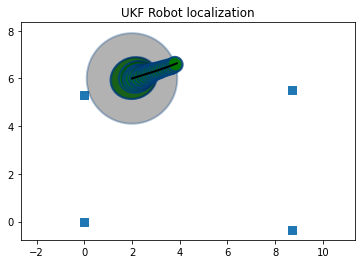

Final P: [0.00254195 0.00253867 0.00056879]


In [12]:
landmarks = np.array([[0, 0], [8.692, -0.347], [8.692, 5.519], [0, 5.295]])
# At the same time of remote control, the cmd should also be recorded directly or derived!

dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
    return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  

for _ in range(4):
    # accelerate from a stop
    cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
    cmds.extend([cmds[-1]]*50)

    # turn left
    v = cmds[-1][0]
    cmds.extend(turn(v, 0, 2, 15))
    cmds.extend([cmds[-1]]*100)

ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())